Importing all the required Modules

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense

Downloading the dataset

In [2]:
!gdown --id 108jAePKK4R3BVYBbYJZ32JWUwxeMg20K

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=108jAePKK4R3BVYBbYJZ32JWUwxeMg20K
To: /content/sonnets.txt
100% 93.6k/93.6k [00:00<00:00, 135MB/s]


In [3]:
sonnet_file = "/content/sonnets.txt"

with open(sonnet_file, "r") as f:
  data = f.read()

corpus = data.lower().split("\n")

for line in corpus:
  print(line)

from fairest creatures we desire increase,
that thereby beauty's rose might never die,
but as the riper should by time decease,
his tender heir might bear his memory:
but thou, contracted to thine own bright eyes,
feed'st thy light'st flame with self-substantial fuel,
making a famine where abundance lies,
thyself thy foe, to thy sweet self too cruel.
thou that art now the world's fresh ornament
and only herald to the gaudy spring,
within thine own bud buriest thy content
and, tender churl, makest waste in niggarding.
pity the world, or else this glutton be,
to eat the world's due, by the grave and thee.
when forty winters shall beseige thy brow,
and dig deep trenches in thy beauty's field,
thy youth's proud livery, so gazed on now,
will be a tatter'd weed, of small worth held:
then being ask'd where all thy beauty lies,
where all the treasure of thy lusty days,
to say, within thine own deep-sunken eyes,
were an all-eating shame and thriftless praise.
how much more praise deserved thy b

Initializing the tokenizer

In [4]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1 # adding 1 because of the <EOS>

Making the input data

In [5]:
def n_gram_seqs(data, tokenizer):
  input_seq = []

  for line in data:
    token_list = tokenizer.texts_to_sequences([line])[0]

    for i in range(1, len(token_list)):
      n_gram_seq = token_list[: i+1]
      input_seq.append(n_gram_seq[: i+1])

  return input_seq

In [6]:
first_3_examples_sequence = n_gram_seqs(corpus[0:3], tokenizer)

print("n_gram sequences for first 3 examples look like this:\n")
first_3_examples_sequence

n_gram sequences for first 3 examples look like this:



[[34, 417],
 [34, 417, 877],
 [34, 417, 877, 166],
 [34, 417, 877, 166, 213],
 [34, 417, 877, 166, 213, 517],
 [8, 878],
 [8, 878, 134],
 [8, 878, 134, 351],
 [8, 878, 134, 351, 102],
 [8, 878, 134, 351, 102, 156],
 [8, 878, 134, 351, 102, 156, 199],
 [16, 22],
 [16, 22, 2],
 [16, 22, 2, 879],
 [16, 22, 2, 879, 61],
 [16, 22, 2, 879, 61, 30],
 [16, 22, 2, 879, 61, 30, 48],
 [16, 22, 2, 879, 61, 30, 48, 634]]

In [7]:
input_seq = n_gram_seqs(corpus, tokenizer)
max_len_seq = max([len(x) for x in input_seq])

print(f"n_grams of input_sequences have length: {len(input_seq)}")
print(f"maximum length of sequences is: {max_len_seq}")

n_grams of input_sequences have length: 15462
maximum length of sequences is: 11


In [8]:
def pad_seqs(input_seq, maxlen):
  input_seq = pad_sequences(
      input_seq,
      maxlen = maxlen,
      padding = "pre"
  )

  return input_seq

In [9]:
first_3_padded_seq = pad_seqs(first_3_examples_sequence, max([len(s) for s in first_3_examples_sequence]))
first_3_padded_seq

array([[  0,   0,   0,   0,   0,   0,  34, 417],
       [  0,   0,   0,   0,   0,  34, 417, 877],
       [  0,   0,   0,   0,  34, 417, 877, 166],
       [  0,   0,   0,  34, 417, 877, 166, 213],
       [  0,   0,  34, 417, 877, 166, 213, 517],
       [  0,   0,   0,   0,   0,   0,   8, 878],
       [  0,   0,   0,   0,   0,   8, 878, 134],
       [  0,   0,   0,   0,   8, 878, 134, 351],
       [  0,   0,   0,   8, 878, 134, 351, 102],
       [  0,   0,   8, 878, 134, 351, 102, 156],
       [  0,   8, 878, 134, 351, 102, 156, 199],
       [  0,   0,   0,   0,   0,   0,  16,  22],
       [  0,   0,   0,   0,   0,  16,  22,   2],
       [  0,   0,   0,   0,  16,  22,   2, 879],
       [  0,   0,   0,  16,  22,   2, 879,  61],
       [  0,   0,  16,  22,   2, 879,  61,  30],
       [  0,  16,  22,   2, 879,  61,  30,  48],
       [ 16,  22,   2, 879,  61,  30,  48, 634]], dtype=int32)

In [10]:
input_seq = pad_seqs(input_seq, max_len_seq)

print(f"Padded corpus has shape {input_seq.shape}")

Padded corpus has shape (15462, 11)


In [11]:
def features_and_labels(input_seq, total_words):
  xs = input_seq[:, :-1]
  labels = input_seq[:, -1]

  ys = to_categorical(
      labels,
      num_classes = total_words
  )

  return xs, ys

In [12]:
features, labels = features_and_labels(input_seq, total_words)

print(f"features have shape: {features.shape}")
print(f"labels have shape: {labels.shape}")

features have shape: (15462, 10)
labels have shape: (15462, 3211)


Model

In [13]:
class LSTM_Model(tf.keras.Model):

  def __init__(self, total_words, max_len_seq):
    super(LSTM_Model, self).__init__()

    self.embedding = Embedding(total_words, 100, input_length = max_len_seq-1)

    self.lstm1 = Bidirectional(LSTM(150, dropout = 0.2, return_sequences = True))
    self.lstm2 = Bidirectional(LSTM(100, dropout = 0.2))

    self.fc1 = Dense(total_words/2, activation = tf.nn.relu)
    self.fc2 = Dense(total_words, activation = tf.nn.softmax)

  def call(self, inputs):

    x = inputs

    x = self.embedding(x)

    x = self.lstm1(x)
    x = self.lstm2(x)

    x = self.fc1(x)
    x = self.fc2(x)

    return x

In [14]:
model = LSTM_Model(total_words, max_len_seq)

In [15]:
model.compile(
    loss = "categorical_crossentropy",
    optimizer = "adam",
    metrics = ["accuracy"]
)

In [17]:
history = model.fit(
    features,
    labels,
    epochs = 50,
    verbose = 1
)

Epoch 1/50
484/484 [==============================] - 16s 32ms/step - loss: 6.8058 - accuracy: 0.0217
Epoch 2/50
484/484 [==============================] - 8s 17ms/step - loss: 6.4357 - accuracy: 0.0311
Epoch 3/50
484/484 [==============================] - 7s 14ms/step - loss: 6.2051 - accuracy: 0.0389
Epoch 4/50
484/484 [==============================] - 7s 15ms/step - loss: 5.9466 - accuracy: 0.0465
Epoch 5/50
484/484 [==============================] - 7s 14ms/step - loss: 5.6700 - accuracy: 0.0569
Epoch 6/50
484/484 [==============================] - 8s 17ms/step - loss: 5.3870 - accuracy: 0.0704
Epoch 7/50
484/484 [==============================] - 6s 13ms/step - loss: 5.0936 - accuracy: 0.0852
Epoch 8/50
484/484 [==============================] - 7s 14ms/step - loss: 4.7836 - accuracy: 0.1004
Epoch 9/50
484/484 [==============================] - 7s 15ms/step - loss: 4.4606 - accuracy: 0.1246
Epoch 10/50
484/484 [==============================] - 6s 13ms/step - loss: 4.0916 - accur

In [18]:
def plot_graph(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.title("training "+string.upper())
  plt.show()

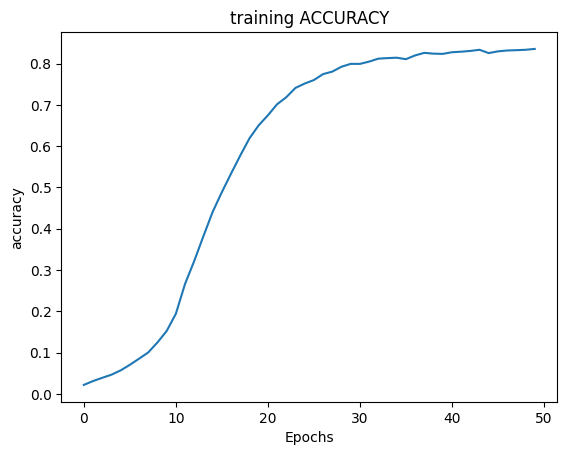

In [19]:
plot_graph(history, "accuracy")

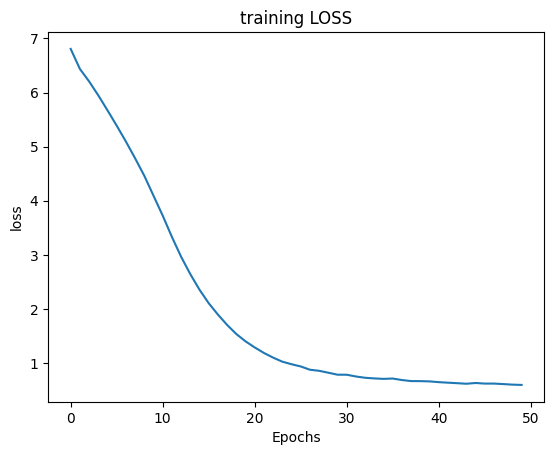

In [20]:
plot_graph(history, "loss")

In [21]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100

for _ in range(next_words):
  token_list = tokenizer.texts_to_sequences([seed_text])[0]

  token_list = pad_sequences(
      [token_list],
      maxlen = max_len_seq - 1,
      padding = "pre"
  )

  predicted = model.predict(token_list, verbose = 0)

  predicted = np.argmax(predicted, axis = -1).item()

  output_word = tokenizer.index_word[predicted]

  seed_text = seed_text + " " + output_word

In [22]:
print(seed_text)

Help me Obi Wan Kenobi, you're my only hope out her young alone latch repair in me and the heart is took the sun of hide of nought to crave ' latch thee in the heart doth love thee more doth cross'd sheds it so belong so near bring call her more near ' ' thee in me so own worth do call the plea mad doth bell night doth part me ' in latch dead lie thee me to me do now do thy fair heart go back to share me thine own part i be ranged old 'will ' ' of me so be the heart of
